# Veron's Notebook

This project notebook replicates the work presented in the final report (ADD LINK).

#### Imports

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Custom utils functions
import sys; sys.path.append("./libraries/")
from utils import *

#### Settings

In [2]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"

# Flags
process = False

# Data

## Load and match datasets
We have two different dataset sources with different identifiers. To match players from Transfermarkt with their attributes from soFIFA, we use a custom function that looks at their names, date of birth and nationality to ensure they are the same player.

In [3]:
# If process, load raw data and apply matching between datasets 
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    players = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    ratings22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    ratings21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(ratings21.sofifa_id).difference(set(ratings22.sofifa_id))
    FIFA = pd.concat([ratings22, ratings21[ratings21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    players.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(players, FIFA)
    # Append the extracted FIFA long names
    players["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    players["fifa_id"] = players["FIFA_long_name"] + "-" + pd.to_datetime(players["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = players.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Get valuation data
valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
# ... (we can get some more datasets if needed)

# Glance at data
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


In [4]:
print(list(players.columns))

['player_id', 'first_name', 'last_name', 'FIFA_long_name', 'last_season', 'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'date_of_birth', 'sub_position', 'position', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 'contract_expiration_date', 'current_club_domestic_competition_id', 'current_club_name', 'fifa_id', 'short_name', 'long_name', 'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'dob', 'height_cm', 'weight_kg', 'club_name', 'league_name', 'league_level', 'club_contract_valid_until', 'nationality_name', 'nation_position', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'release_clause_eur', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_l

In [5]:
print(list(valuations.columns))

['player_id', 'last_season', 'datetime', 'date', 'dateweek', 'market_value_in_eur', 'n', 'current_club_id', 'player_club_domestic_competition_id']


In [6]:
print(list(players["league_name"]))

['Scottish Premiership', 'Belgian Jupiler Pro League', 'Swedish Allsvenskan', 'English Premier League', 'Turkish Süper Lig', 'Belgian Jupiler Pro League', 'English League Championship', 'Scottish Premiership', 'French Ligue 1', 'French Ligue 2', 'Italian Serie A', 'Greek Super League', 'Spanish Segunda División', 'Italian Serie A', 'Turkish Süper Lig', 'German 1. Bundesliga', 'Mexican Liga MX', 'Turkish Süper Lig', nan, 'Belgian Jupiler Pro League', 'French Ligue 1', 'Italian Serie A', 'Spanish Segunda División', 'USA Major League Soccer', 'Turkish Süper Lig', 'Turkish Süper Lig', 'Scottish Premiership', 'English League Two', 'English Premier League', 'German 3. Bundesliga', 'Greek Super League', 'Indian Super League', 'German 3. Bundesliga', 'Scottish Premiership', 'Belgian Jupiler Pro League', 'French Ligue 1', 'English League Two', 'Scottish Premiership', 'Portuguese Liga ZON SAGRES', 'Spain Primera Division', 'German 2. Bundesliga', 'German 1. Bundesliga', 'Turkish Süper Lig', 'Eng

###  Players' last season count

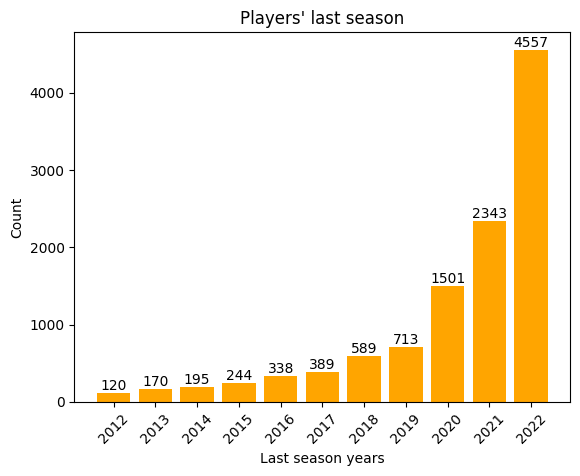

In [7]:
leagues = players["last_season"].value_counts()

fig, ax = plt.subplots()

bars = ax.bar(leagues.index, leagues.values, color="orange")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')

x = np.arange(2012, 2023, 1)
plt.title("Players' last season")
plt.xlabel("Last season years")
plt.ylabel("Count")
plt.xticks(x, rotation=45)
plt.show()

### Calculating mean on the Age of players playing in the leagues with most players 

In [8]:
players_groupby_league = players.groupby("league_name").size()

top_10_leagues_with_most_players = players_groupby_league.sort_values(ascending=False).head(5).index

mean_age_by_league = {}

for league in top_10_leagues_with_most_players:
    mean_age = players[players["league_name"] == league]["age"].mean().round(1)
    mean_age_by_league[league] = mean_age
    
# for league, mean_age in mean_age_by_league.items():
#     print(f"League: {league}, Average age: {mean_age}")
    
print(f"{'League':<30} {' Average age':>22}")
print("-" * 53)
for league, mean_age in mean_age_by_league.items():
    print(f"{league:<30} {mean_age:>20.1f}")

League                                    Average age
-----------------------------------------------------
Turkish Süper Lig                              26.6
Italian Serie A                                26.0
Spain Primera Division                         25.8
English Premier League                         25.0
Portuguese Liga ZON SAGRES                     24.9


### Average market value in top 5 leagues with most players

In [9]:
players_groupby_league = players.groupby("league_name").size()

top_10_leagues_with_most_players = players_groupby_league.sort_values(ascending=False).head(5).index

mean_value_by_league = {}

for league in top_10_leagues_with_most_players:
    mean_value = players[players["league_name"] == league]["market_value_in_eur"].mean().round(1)
    mean_value_by_league[league] = mean_value
    
# for league, mean_value in mean_value_by_league.items():
#     print(f"League: {league}, Average Market Value (EUR): {mean_value}")
    
print(f"{'League':<30} {'Average Market Value (EUR)':>20}")
print("-" * 58)
for league, mean_value in mean_value_by_league.items():
    print(f"{league:<30} {mean_value:>25}" )

League                         Average Market Value (EUR)
----------------------------------------------------------
Turkish Süper Lig                              1291961.9
Italian Serie A                                6685962.1
Spain Primera Division                         6892268.4
English Premier League                        13532166.4
Portuguese Liga ZON SAGRES                     2718170.5
